# **ECON 412: Project 1**
#### *Group Members:* Courtney Manhart, Martin Jamouss, Steven Spear Jr, Lindsay Mahowald


## **I. Introduction**
### **Background on the Topic**
To understand employment levels in an economy is the beginning of understanding the health of that economy. Forecasts of employment give policymakers an opportunity to understand policy impacts and make adjustments to promote every person's livelihood. This project will adjust U.S. employment data for trends and seasonality, compare different forecasting models, and suggest improvements for future work.

### **Dataset Description**
Monthly, not seasonally adjusted employment level data measured in thousands of persons from the U.S. Bureau of Labor Statistics Current Population Survey (Household Survey) via FRED. The civilian noninstitutional population is defined as: persons 16 years of age and older residing in the 50 states and the District of Columbia, who are not inmates of institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces.

In [ ]:
# Import Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import altair as alt
import datetime
import statsmodels.formula.api as smf


import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Import Dataset
filepath='/content/gdrive/MyDrive/ECON 412 - Projects/Project 1/Employment-Level.csv'
data = pd.read_csv(filepath,
                   parse_dates=True, index_col='DATE')

# Creating a Time Dummy
T = len(data)
time = np.arange(0, T)
data['Time'] = time

# Renaming a Column
data = data.rename(columns={'LNU02000000': 'Employment_Level'})

# Displaying the Updated DataFrame
data.head()

,Employment_Level,Time
DATE,,
1948-01-01,56339,0
1948-02-01,56440,1
1948-03-01,56601,2
1948-04-01,57471,3
1948-05-01,57763,4


## **II. Results**
### **1. Modeling and Forecasting Trend**
#### **(a) Time-Series Plot of the Data.**

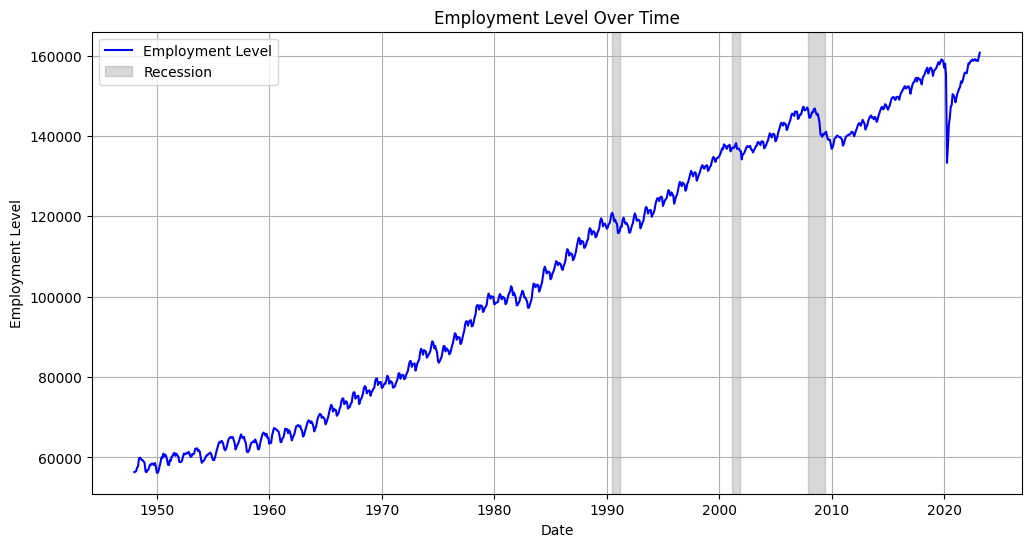

In [ ]:
# Recessions
recessions = [
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01')
]

# Function to add recession shading to plot
def add_recession_shading(ax, recent=None):
    if recent is not None:
        recs_to_plot = recessions[-recent:]
    else:
        recs_to_plot = recessions

    for i, (start, end) in enumerate(recs_to_plot):
# Add label only for the first shaded area to avoid duplicates in the legend
        if i == 0:  
            label = 'Recession'
        else:
            label = None
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                   color='gray', alpha=0.3, label=label)

# Time-Series Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data['Employment_Level'], color='blue', 
        label='Employment Level')
ax.set(title='Employment Level Over Time', xlabel='Date', 
       ylabel='Employment Level')
add_recession_shading(ax)
ax.grid(True)
ax.legend(loc='upper left')
plt.show()


#### **(b) Does the plot in (a) suggest that the data is covariance stationary? Explain**

The time series lacks covariance stationarity and shows a clear increasing trend without mean-reversion.

#### **(c) Plot and discuss the ACF and PACF of the data**

<Figure size 1500x600 with 0 Axes>

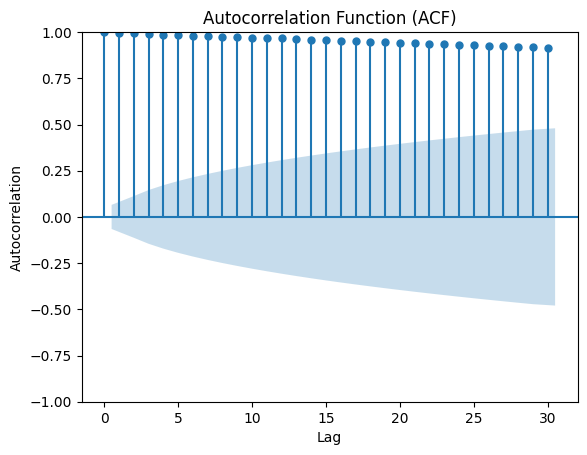

In [ ]:
# Plot ACF
plt.figure(figsize = (15, 6)) 
plot_acf(data['Employment_Level'])


plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.show()


Upon examining the ACF, we can see a clear pattern of decay in the autocorrelation values as the lag increases. This suggests that there is little to no significant autocorrelation in the data beyond a few lags. 

To gain a deeper understanding of the autocorrelation structure of the data and make informed decisions about modeling and forecasting the time series, we will analyze the partial autocorrelation function (PACF). By doing so, we can identify the appropriate order of autoregressive terms for our time series model and ensure that it accurately captures the essential characteristics of the data.

<Figure size 1500x600 with 0 Axes>

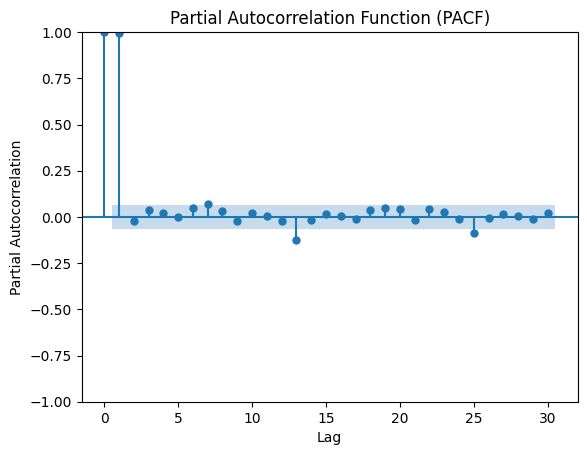

In [ ]:
# Plot PACF
plt.figure(figsize = (15, 6)) 
plot_pacf(data['Employment_Level'])


plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.show()

After analyzing the partial autocorrelation function (PACF), which measures the correlation between a time series and a lagged version of itself while controlling for the correlation at shorter lags, we found significant partial autocorrelation at lag 1, 14, and 25.

#### **(d) Fit a linear and nonlinear (e.g. polynomial, exponential, quadratic + periodic, etc.) model to your series. In one window, show both figures of the original time series plot with the respective fit**

##### *Linear Model*

In [ ]:
# Fit the Model
lin_trend = smf.ols('Employment_Level ~ Time', data = data).fit()
lin_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Employment_Level   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 4.639e+04
Date:                Sat, 22 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:42:07   Log-Likelihood:                -8889.7
No. Observations:                 903   AIC:                         1.778e+04
Df Residuals:                     901   BIC:                         1.779e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.978e+04    303.769    163.861      0.000    4.92e+04    5.04e+04
Time         125.5940      0.583    215.373      0.000     124.449     126.738
==============================================================================
Omnibus:                       20.812   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.033
Skew:                          -0.302   Prob(JB):                     6.04e-06
Kurtosis:                       3.523   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

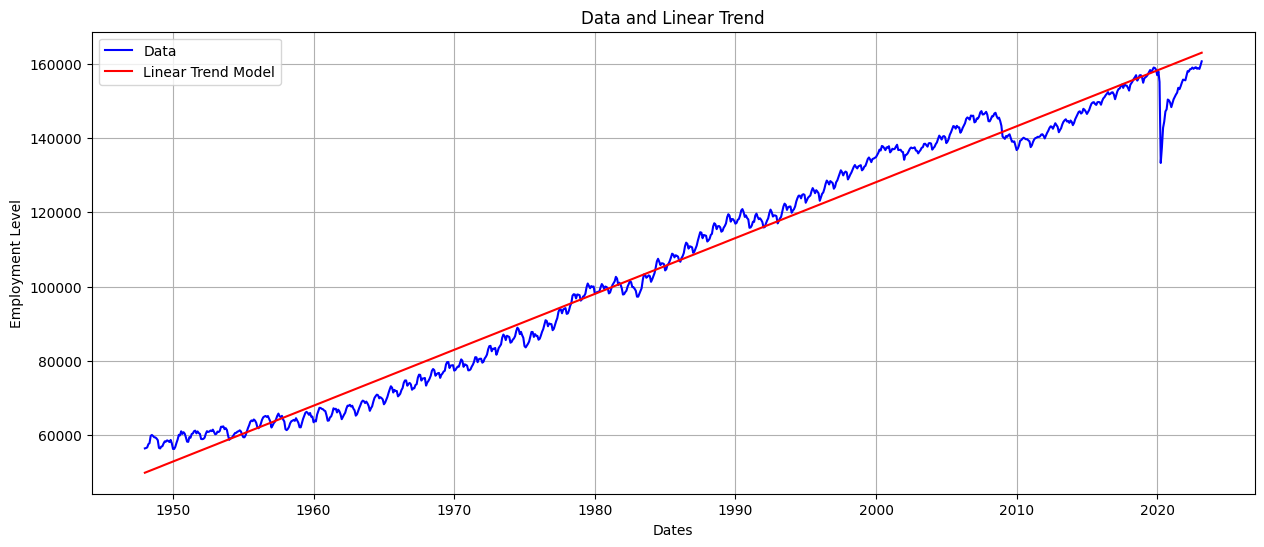

In [ ]:
# Gathering fitted values
y_linfit = lin_trend.fittedvalues

# Plot the Data & Model
plt.figure(figsize = (15, 6))

plt.plot(data.index, data['Employment_Level'], 
         color = 'blue', label = 'Data')
plt.plot(data.index, y_linfit, 
         color = 'red', label = 'Linear Trend Model')

plt.title('Data and Linear Trend')
plt.xlabel('Dates')
plt.ylabel('Employment Level')

plt.legend()
plt.grid()
plt.show()

##### *Nonlinear Model*

In [ ]:
# Fit the Model
nonlin_trend = smf.ols('Employment_Level ~ Time + I(Time ** 2) + I(Time ** 3)', 
                       data = data).fit()
nonlin_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Employment_Level   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 4.025e+04
Date:                Sat, 22 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:42:16   Log-Likelihood:                -8462.0
No. Observations:                 903   AIC:                         1.693e+04
Df Residuals:                     899   BIC:                         1.695e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.784e+04    377.507    153.216      0.000    5.71e+04    5.86e+04
Time             9.9284      3.627      2.738      0.006       2.811      17.046
I(Time ** 2)     0.3342      0.009     35.756      0.000       0.316       0.353
I(Time ** 3)    -0.0003   6.81e-06    -37.234      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      168.782   Durbin-Watson:                   0.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              542.958
Skew:                          -0.898   Prob(JB):                    1.25e-118
Kurtosis:                       6.347   Cond. No.                     1.11e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

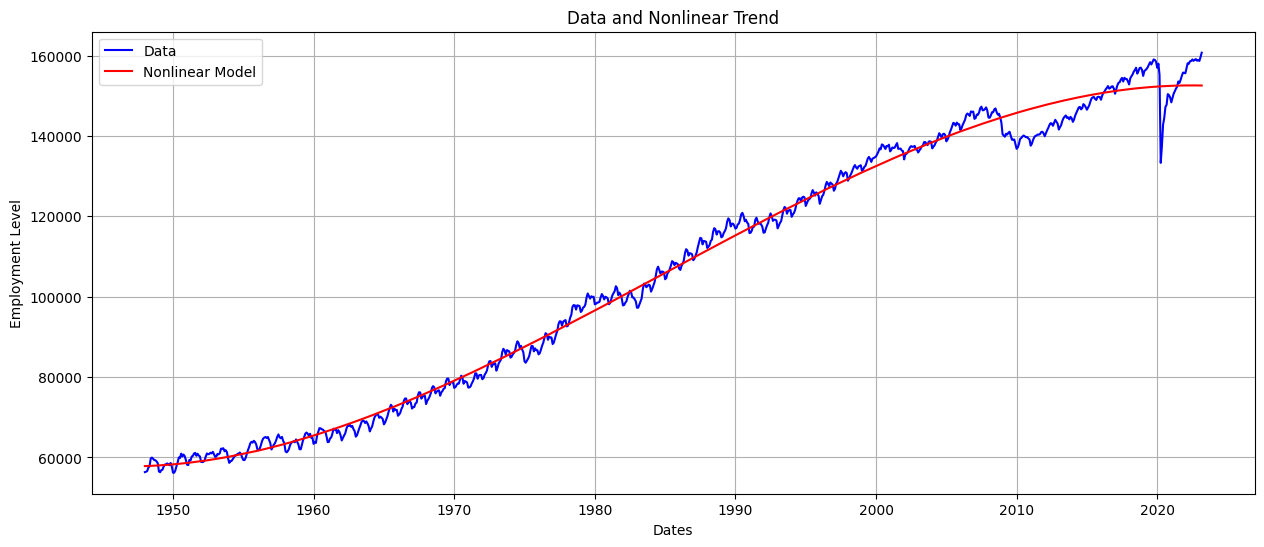

In [ ]:
# Gathering fitted values
y_nonlinfit = nonlin_trend.fittedvalues


# Plot the Data & Model
plt.figure(figsize = (15, 6))

plt.plot(data.index, data['Employment_Level'], 
         color = 'blue', label = 'Data')
plt.plot(data.index, y_nonlinfit, color = 'red', 
         label = 'Nonlinear Model')


plt.title('Data and Nonlinear Trend')
plt.xlabel('Dates')
plt.ylabel('Employment Level')

plt.legend()
plt.grid()
plt.show()

Given the visual inspection of the data, it seems that a nonlinear model (in this case, adding a quadratic and cubic term) slightly improves the fit.

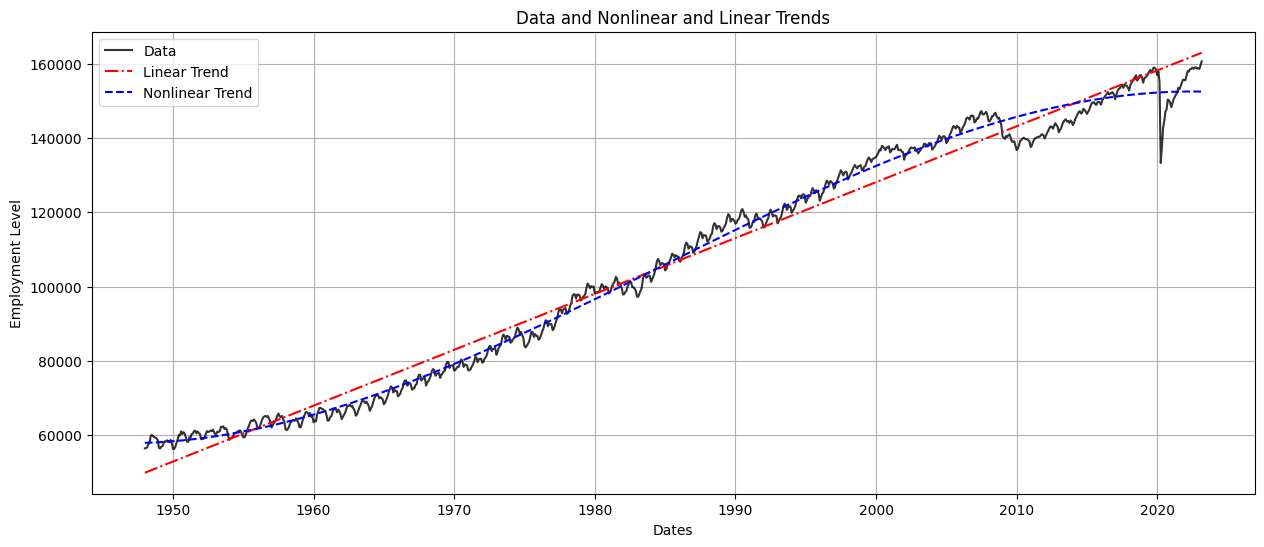

In [ ]:
# Plot the Data & Model
plt.figure(figsize = (15, 6))

plt.plot(data.index, data['Employment_Level'], 
         color = 'black', alpha = 0.8, label = 'Data')
plt.plot(data.index, y_linfit, color = 'red', linestyle = "-.",
         label = 'Linear Trend')
plt.plot(data.index, y_nonlinfit, color = 'blue', linestyle = '--',
         label = 'Nonlinear Trend')

plt.title('Data and Nonlinear and Linear Trends')
plt.xlabel('Dates')
plt.ylabel('Employment Level')

plt.legend()
plt.grid()
plt.show()

#### **(e) For each model, plot the respective residuals vs fitted values and discuss your observations**

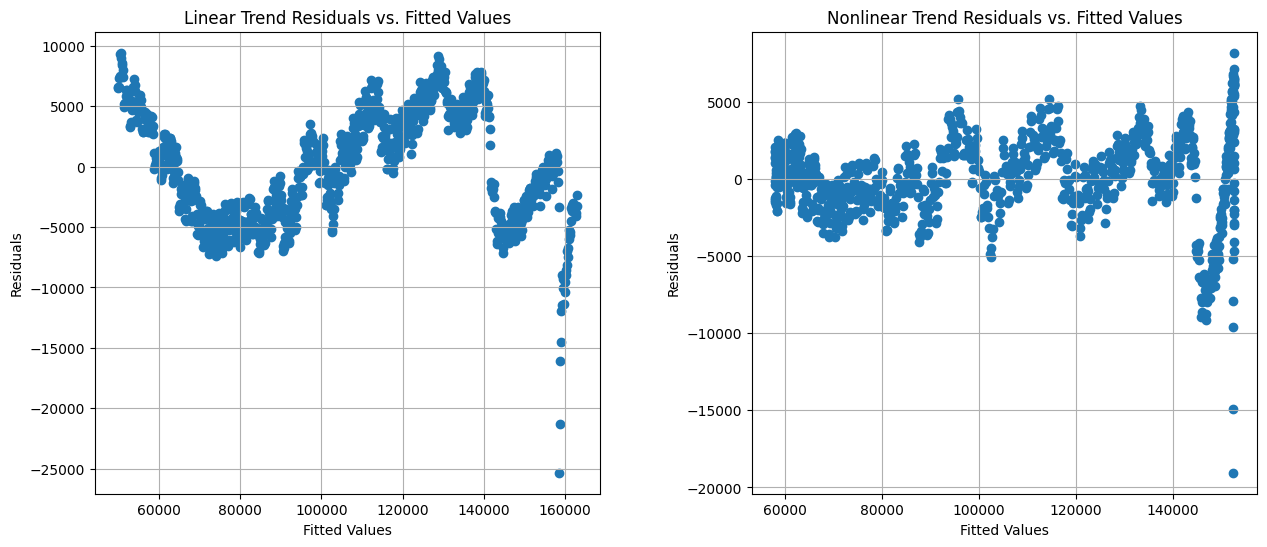

In [ ]:
# Calculating Residuals
lin_resids = lin_trend.resid
nonlin_resids = nonlin_trend.resid

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Residuals vs Fitted Values - Linear
ax[0].scatter(y_linfit, lin_resids)

ax[0].set_title('Linear Trend Residuals vs. Fitted Values')
ax[0].set_xlabel('Fitted Values')
ax[0].set_ylabel('Residuals')

ax[0].grid()

# Plot Residuals vs Fitted Values - Nonlinear
ax[1].scatter(y_nonlinfit, nonlin_resids)

ax[1].set_title('Nonlinear Trend Residuals vs. Fitted Values')
ax[1].set_xlabel('Fitted Values')
ax[1].set_ylabel('Residuals')

ax[1].grid()

plt.subplots_adjust(wspace=0.3)
plt.show()

The residuals of both models appear to be scattered around zero, indicating that the models captures the overall trend of the data. However, some noise and pattern is still present in the residuals, which may suggest the existence of cyclicity in the data. Notably, caution should be exercised when interpreting the residuals during the period where COVID-19 struck, as the employment level experienced a significant shock during that time, and the residuals in recent years deviate from this trend.

#### **(f) For each model, plot a histogram of the residuals and discuss your observations.**

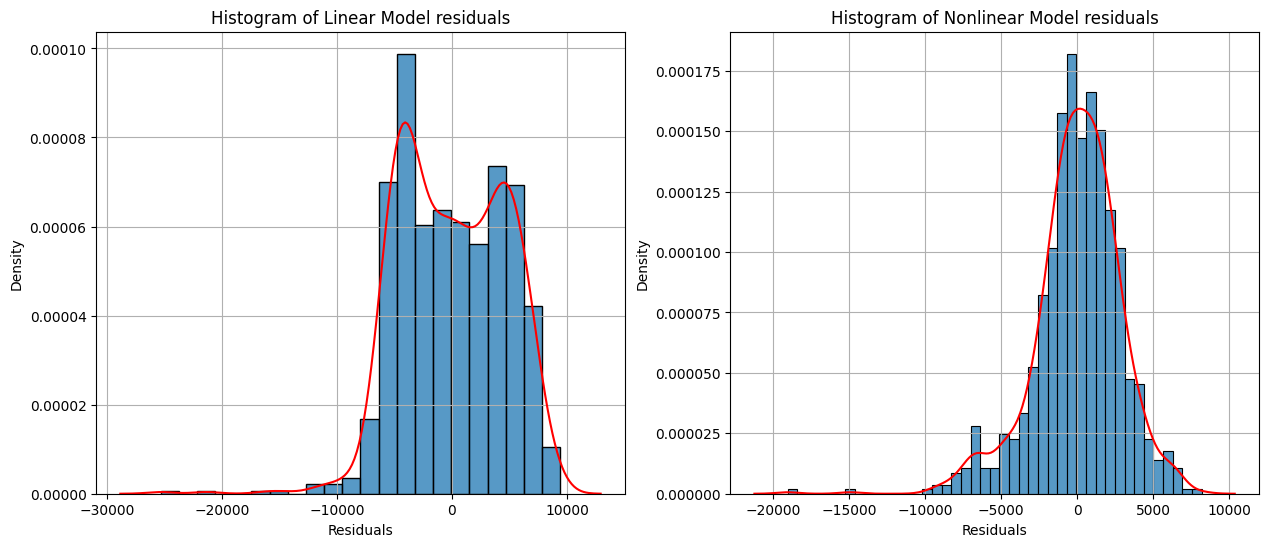

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))

# Plot a histogram of Residuals - Linear Model
sns.histplot(lin_resids, stat = 'density', ax = ax[0])
sns.kdeplot(lin_resids, color = 'red', ax = ax[0])


ax[0].set_title('Histogram of Linear Model residuals')
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Density')

ax[0].grid()

# Plot a histogram of Residuals - Nonlinear Model
sns.histplot(nonlin_resids, stat = 'density', ax = ax[1])
sns.kdeplot(nonlin_resids, color = 'red', ax = ax[1])

ax[1].set_title('Histogram of Nonlinear Model residuals')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Density')

ax[1].grid()

plt.show()

Each histogram shows a normal distribution with a mean of zero, indicating that the residuals are centered around zero. However, the residuals of the exponential model appear to be slightly more normally distributed than the residuals of the linear model. Additionally, the residuals in both plots appear to skew slightly to the right, indicating that the residuals are slightly more positive than negative. 

#### **(g) For each model, discuss the associated diagnostic statistics (R-Squared, t-distributions, F-distributions, etc).**

##### *Linear Model*

In [ ]:
# R-squared
lin_r2 = lin_trend.rsquared
print('Linear Model R-Squared:', lin_r2)

# t-distributions
lin_t = lin_trend.tvalues
print('Linear Model T-Test:')
print(lin_t)

# F-distribution
lin_f = lin_trend.fvalue
print('Linear Model F-Value:', lin_f)

Linear Model R-Squared: 0.9809460025806149
Linear Model T-Test:
Intercept    163.861375
Time         215.373316
dtype: float64
Linear Model F-Value: 46385.6653736053


##### *Nonlinear Model*

In [ ]:
# R-squared, t-distributions, F-distributions
nonlin_r2 = nonlin_trend.rsquared
print('Nonlinear Model R-Squared:', nonlin_r2)

# t-distributions
nonlin_t = nonlin_trend.tvalues
print('Nonlinear Model T-Test:')
print(nonlin_t)

print(nonlin_trend.t_test)

# F-distribution
nonlin_f = nonlin_trend.fvalue
print('nonlinear Model F-Value:', nonlin_f)

Nonlinear Model R-Squared: 0.9926106688851448
Nonlinear Model T-Test:
Intercept       153.216369
Time              2.737738
I(Time ** 2)     35.756089
I(Time ** 3)    -37.233600
dtype: float64
<bound method LikelihoodModelResults.t_test of <statsmodels.regression.linear_model.OLSResults object at 0x7f18682b3af0>>
nonlinear Model F-Value: 40254.297150739236


Comparing the two models, we see that the nonlinear model has a slightly higher R-Squared value, and a lower F statistic. Comparing out t statistics to a null hypothesis of beta = 0 and assigning a threshold of 1.96, we know that coefficients from both models are all statistically significant. 

#### **(h) Select a trend model using AIC and one using BIC (show the values obtained from each criterion). Do the selected models agree?**

In [ ]:
# AIC 
lin_AIC = lin_trend.aic
nonlin_AIC = nonlin_trend.aic

# BIC 
lin_BIC = lin_trend.bic
nonlin_BIC = nonlin_trend.bic

# Comparisons
pd.DataFrame({'AIC': [lin_AIC, nonlin_AIC],
             'BIC': [lin_BIC, nonlin_BIC]},
            index = ['Linear', 'Nonlinear'])

,AIC,BIC
Linear,17783.421992,17793.033437
Nonlinear,16932.064544,16951.287434


In [ ]:
## AIC
if lin_AIC < nonlin_AIC:
  AIC_mod = 'Linear'
else:
  AIC_mod = 'Nonlinear'
print('AIC Model:', AIC_mod)

## BIC
if lin_BIC < nonlin_BIC:
  BIC_mod = 'Linear'
else:
  BIC_mod = 'Nonlinear'
print('BIC Model:', BIC_mod)

## Do these Agree
print('AIC Model and BIC Model Agree?', AIC_mod == BIC_mod)

AIC Model: Nonlinear
BIC Model: Nonlinear
AIC Model and BIC Model Agree? True


To select the best performing model using AIC and BIC, we select the model with the smallest values. Therefore, based on the AIC value for the linear trend (17783.42) and the AIC value for the nonlinear trend (16932.07), the nonlinear model performs better due to the smaller AIC value. Similarly, based on the BIC value for the linear trend (17793.03) and the BIC value for the nonlinear trend (16951.29), the nonlinear model performs better due to the smaller BIC value. The model selected using AIC agrees with the model selected using BIC. Consequently, the best performing model is the nonlinear trend model. 

#### **(i) Use your preferred model to forecast h-steps (at least 12) ahead. Your forecast should include the respective uncertainty prediction interval. Depending on your data, h will be in days, months, years, etc).**

$$ Y_{T + h, T} = \beta_0 + \beta_1(T+h) + \beta_2(T+h)^2 + \beta_3(T+h)^3 $$

##### *Recursive Scheme*



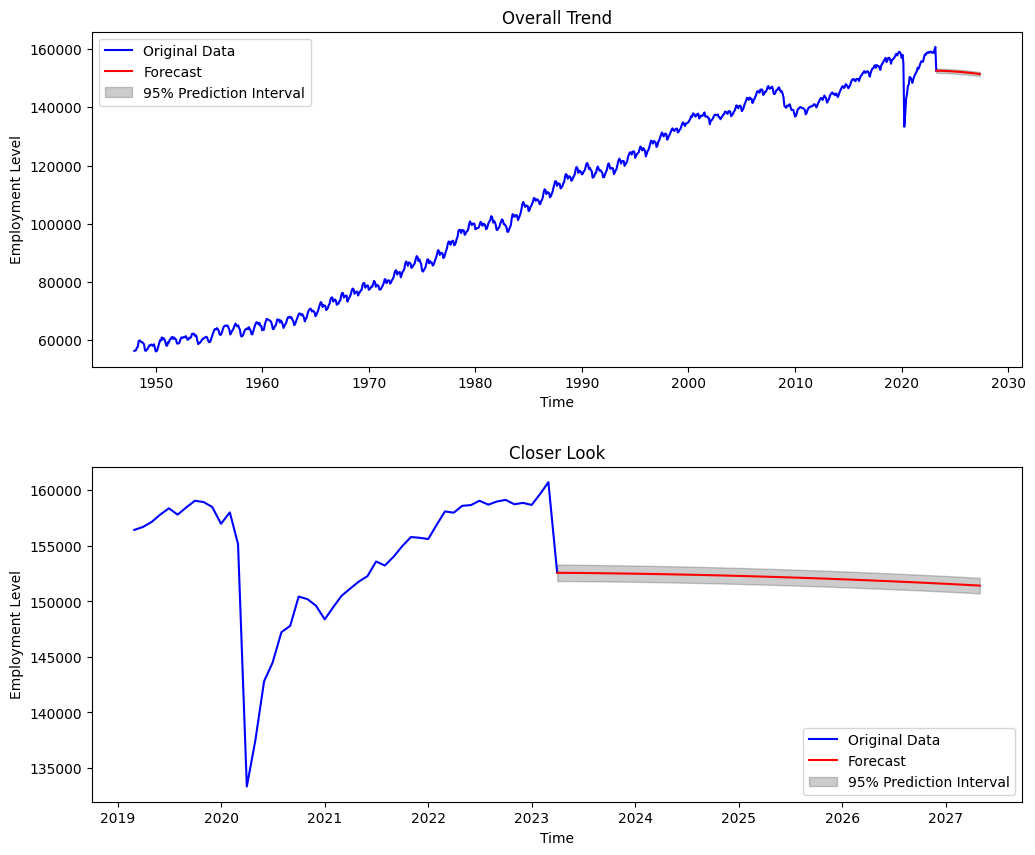

In [ ]:
# Function to fit a linear regression model and 
    # forecast one step ahead with prediction interval
def forecast_one_step(train_data):
    model = smf.ols("Employment_Level ~ Time + I(Time**2) + I(Time**3)", 
                    data=train_data).fit()
    next_x = train_data.iloc[-1]['Time']
    forecast = model.predict(pd.DataFrame({'Time': [next_x]}))[0]
    pred_int = model.get_prediction(pd.DataFrame({
                'Time': [next_x]})).conf_int(alpha=0.05)
    return forecast, pred_int

# Recursive Window Forecasting
recursive_window = None
n_forecasts = 50
train_data = data.iloc[recursive_window:]
forecasts = []
pred_ints = []

for i in range(n_forecasts):
    forecast, pred_int = forecast_one_step(train_data)
    train_data = train_data.append({'Time': train_data.iloc[-1]['Time'] + 1,
                              'Employment_Level': forecast}, ignore_index=True)
    forecasts.append(forecast)
    pred_ints.append(pred_int)

start_date = data.iloc[-1:,:].index[0] + DateOffset(months=1)
TimeStamp = pd.date_range(start=start_date, periods = n_forecasts,
                                      freq='MS').tolist()
forecasts = pd.DataFrame(np.array(forecasts), index=TimeStamp, 
                              columns=['Predictions'])

# Reshape conf_ints array and create DataFrame
pred_ints = np.array(pred_ints).reshape((n_forecasts, 2))
pred_ints = pd.DataFrame(pred_ints, index=TimeStamp, 
                                columns=['Lower', 'Upper'])

# Combine the confidence intervals and forecasts into a 
    # single DataFrame with 'Predictions' in the middle
result = pd.concat([pred_ints['Lower'], forecasts, pred_ints['Upper']], axis=1)

# Prepare data for plotting
train_data = data.iloc[recursive_window:,:]
predictions = result[['Predictions']]
predictions = predictions.rename(columns={'Predictions':'Employment_Level'})
merged_df = pd.concat([data, predictions])

# Split the data into two sets based on a date
split_date = pd.to_datetime('2023-04-01')
pre_date = merged_df.loc[:split_date]
post_date = merged_df.loc[split_date:]

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot overall trend
ax[0].plot(pre_date['Employment_Level'], label='Original Data', color='blue')
ax[0].plot(post_date['Employment_Level'], label='Forecast', color='red')
ax[0].fill_between(result.index, result['Lower'], result['Upper'],
                   color='black', alpha = 0.2, label='95% Prediction Interval')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Employment Level')
ax[0].legend(loc='upper left')
ax[0].set_title('Overall Trend')

# Plot closer look
ax[1].plot(pre_date['Employment_Level'].iloc[-50:], label='Original Data', 
                        color='blue')
ax[1].plot(post_date['Employment_Level'], label='Forecast', color='red')
ax[1].fill_between(result.index, result['Lower'], result['Upper'],
                   color='black', alpha = 0.2, label='95% Prediction Interval')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Employment Level')
ax[1].legend(loc='lower right')
ax[1].set_title('Closer Look')

plt.subplots_adjust(hspace=0.3)
plt.show()

##### *Rolling Scheme*


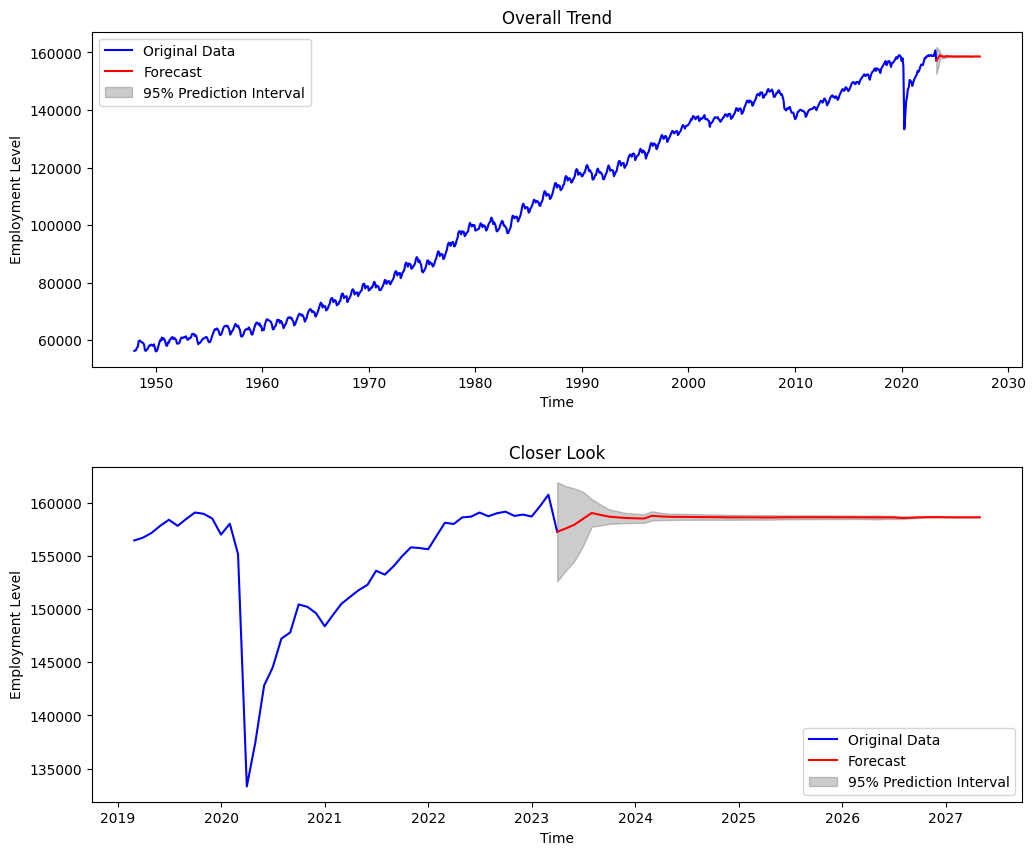

In [ ]:
# Rolling Window Forecasting
rolling_window = -40
n_forecasts = 50
train_data = data.iloc[rolling_window:]
forecasts = []
pred_ints = []

for i in range(n_forecasts):
    forecast, pred_int = forecast_one_step(train_data)
    train_data = train_data.iloc[1:].append({'Time':train_data.iloc[-1]['Time'], 
                              'Employment_Level': forecast}, ignore_index=True)
    forecasts.append(forecast)
    pred_ints.append(pred_int)

start_date = data.iloc[-1:,:].index[0] + DateOffset(months=1)
TimeStamp = pd.date_range(start=start_date, periods = n_forecasts, 
                              freq='MS').tolist()
forecasts = pd.DataFrame(np.array(forecasts), index=TimeStamp, 
                              columns=['Predictions'])

# Reshape conf_ints array and create DataFrame
pred_ints = np.array(pred_ints).reshape((n_forecasts, 2))
pred_ints = pd.DataFrame(pred_ints, index=TimeStamp, 
                              columns=['Lower', 'Upper'])

# Combine the confidence intervals and forecasts into a single 
    # DataFrame with 'Predictions' in the middle
result = pd.concat([pred_ints['Lower'], forecasts, pred_ints['Upper']], axis=1)

# Prepare data for plotting
train_data = data.iloc[rolling_window:,:]
predictions = result[['Predictions']]
predictions = predictions.rename(columns={'Predictions':'Employment_Level'})
merged_df = pd.concat([data, predictions])

# Split the data into two sets based on a date
split_date = pd.to_datetime('2023-04-01')
pre_date = merged_df.loc[:split_date]
post_date = merged_df.loc[split_date:]

# Create Subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot Overall Trend
ax[0].plot(pre_date['Employment_Level'], label='Original Data', color='blue')
ax[0].plot(post_date['Employment_Level'], label='Forecast', color='red')
ax[0].fill_between(result.index, result['Lower'], result['Upper'],
                   color='black', alpha = 0.2, label='95% Prediction Interval')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Employment Level')
ax[0].legend(loc='upper left')
ax[0].set_title('Overall Trend')

# Plot Closer Look
ax[1].plot(pre_date['Employment_Level'].iloc[-50:], label='Original Data',
                      color='blue')
ax[1].plot(post_date['Employment_Level'], label='Forecast', color='red')
ax[1].fill_between(result.index, result['Lower'], result['Upper'],
                   color='black', alpha = 0.2, label='95% Prediction Interval')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Employment Level')
ax[1].legend(loc='lower right')
ax[1].set_title('Closer Look')

plt.subplots_adjust(hspace=0.3)
plt.show()

##### *Fixed Scheme*

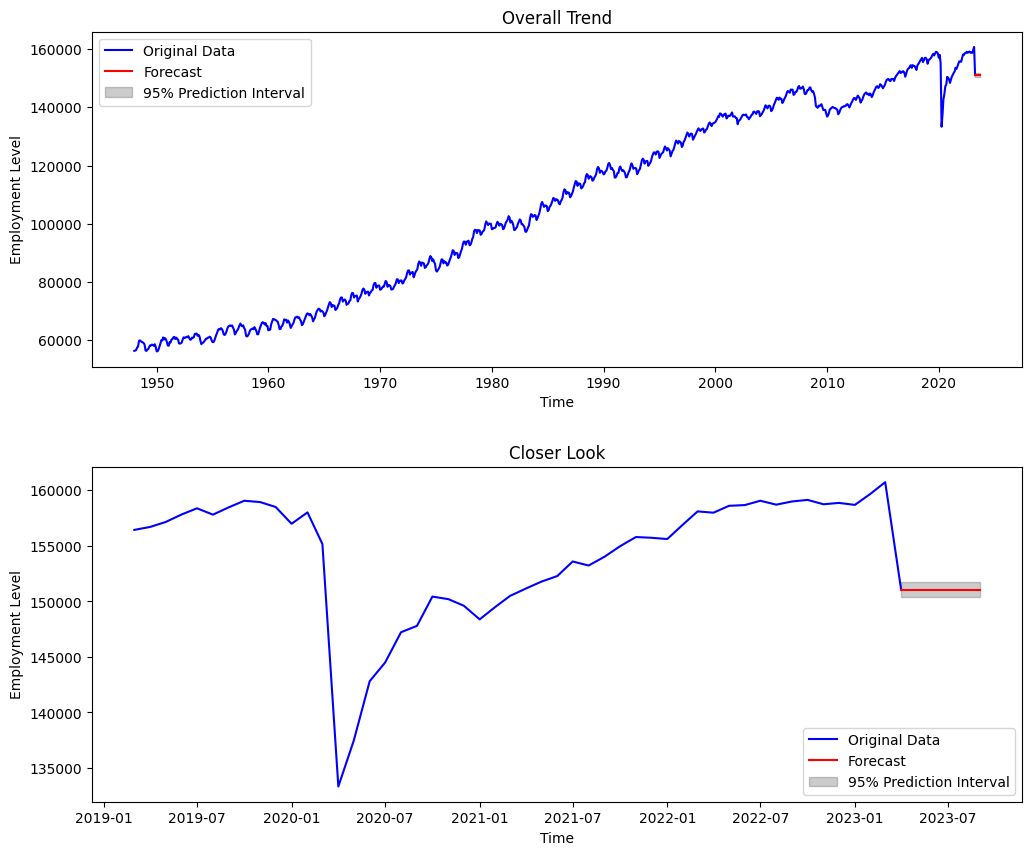

In [ ]:
# Fixed Window Forecasting
n_forecasts = 6

# Use all observations before the COVID-19 pandemic as training data
train_data = data.iloc[:-40] 
  # Drop the last 40 time steps to exclude the COVID-19 pandemic period shock
forecasts = []
pred_ints = []

for i in range(n_forecasts):
    forecast, pred_int = forecast_one_step(train_data)
    forecasts.append(forecast)
    pred_ints.append(pred_int)

start_date = data.iloc[-1:,:].index[0] + DateOffset(months=1)
TimeStamp = pd.date_range(start=start_date, periods = n_forecasts, 
                                  freq='MS').tolist()
forecasts = pd.DataFrame(np.array(forecasts), index=TimeStamp, 
                                  columns=['Predictions'])

# Reshape conf_ints array and create DataFrame
pred_ints = np.array(pred_ints).reshape((n_forecasts, 2))
pred_ints = pd.DataFrame(pred_ints, index=TimeStamp, 
                                  columns=['Lower', 'Upper'])

# Combine the confidence intervals and forecasts 
    # into a single DataFrame with 'Predictions' in the middle
result = pd.concat([pred_ints['Lower'], forecasts, pred_ints['Upper']], axis=1)

# Prepare data for plotting
predictions = result[['Predictions']]
predictions = predictions.rename(columns={'Predictions':'Employment_Level'})
merged_df = pd.concat([data, predictions])

# Split the data into two sets based on a date
split_date = pd.to_datetime('2023-04-01')
pre_date = merged_df.loc[:split_date]
post_date = merged_df.loc[split_date:]

# Create Subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot Overall Trend
ax[0].plot(pre_date['Employment_Level'], label='Original Data', color='blue')
ax[0].plot(post_date['Employment_Level'], label='Forecast', color='red')
ax[0].fill_between(result.index, result['Lower'], result['Upper'],
                   color='black', alpha = 0.2, label='95% Prediction Interval')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Employment Level')
ax[0].legend(loc='upper left')
ax[0].set_title('Overall Trend')

# Plot Closer Look
ax[1].plot(pre_date['Employment_Level'].iloc[-50:], 
                        label='Original Data', color='blue')
ax[1].plot(post_date['Employment_Level'], label='Forecast', color='red')
ax[1].fill_between(result.index, result['Lower'], result['Upper'],
                   color='black', alpha = 0.2, label='95% Prediction Interval')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Employment Level')
ax[1].legend(loc='lower right')
ax[1].set_title('Closer Look')

plt.subplots_adjust(hspace=0.3)
plt.show()

### **2. Trend and Seasonal Adjustments**

#### **(a) Perform an additive decomposition of your series. Remove the trend and seasonality, and comment on the ACF and PACF of the residuals (i.e. what is left after detrending and seasonally adjusting the series). Comment on the results.** 

<Figure size 1500x1500 with 0 Axes>

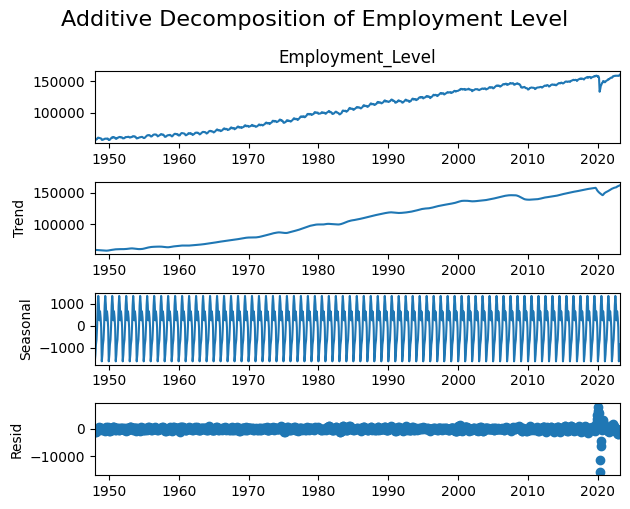

In [ ]:
# Perform additive decomposition on the 'Employment_Level' variable
decompose_add = seasonal_decompose(data['Employment_Level'], 
                                   model='additive', extrapolate_trend='freq')

# Set the figure size for the resulting decomposition plot
plt.figure(figsize=(15, 15))

# Plot the decomposition
decompose_add.plot()

# Add a title and subtitle with appropriate spacing
plt.suptitle('Additive Decomposition of Employment Level', y=1.05, fontsize=16)
plt.title('', y=1.15)

# Show the plot
plt.show()


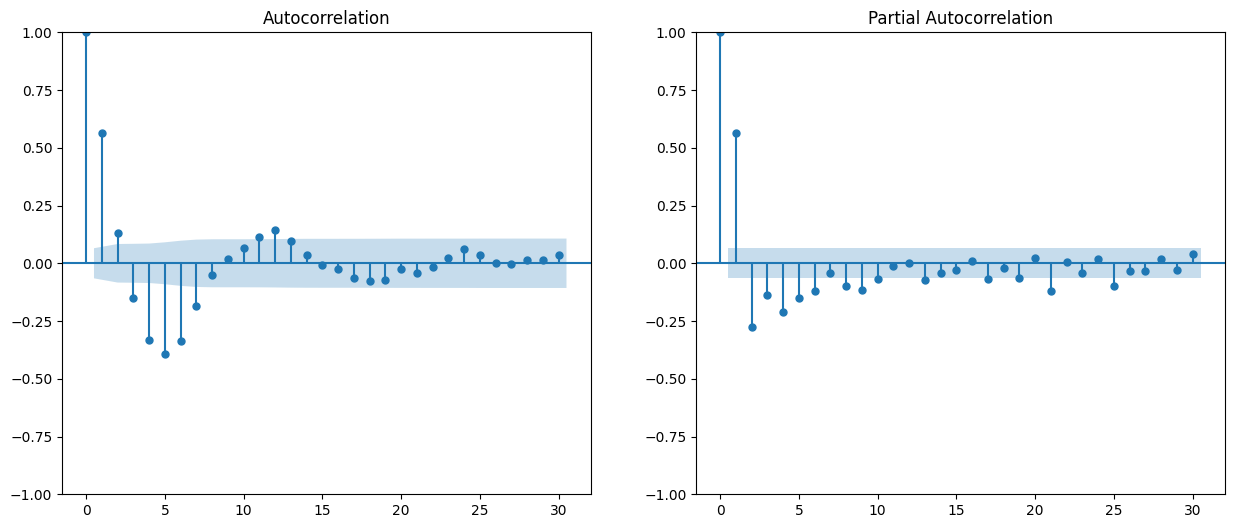

In [ ]:
# Remove Trend and Seasonality
trend = decompose_add.trend
seasonality = decompose_add.seasonal

residsA = data['Employment_Level'] - trend - seasonality

# Plot ACF and PACF of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(residsA, ax=ax1)
plot_pacf(residsA, ax=ax2)
plt.show()


After performing an additive decomposition of the time-series data into its trend, seasonal, and residual components, we observed that the ACF and PACF plots of the residuals suggest the presence of some cyclicity. This indicates that there may be cyclical patterns in the data that have not been fully accounted for in the decomposition or that the data.

#### **(b) Perform a multiplicative decomposition of your series. Remove the trend and seasonality, and comment on the ACF and PACF of the residuals (i.e. what is left after detrending and seasonally adjusting the series). Comment on the results.**

<Figure size 1500x1500 with 0 Axes>

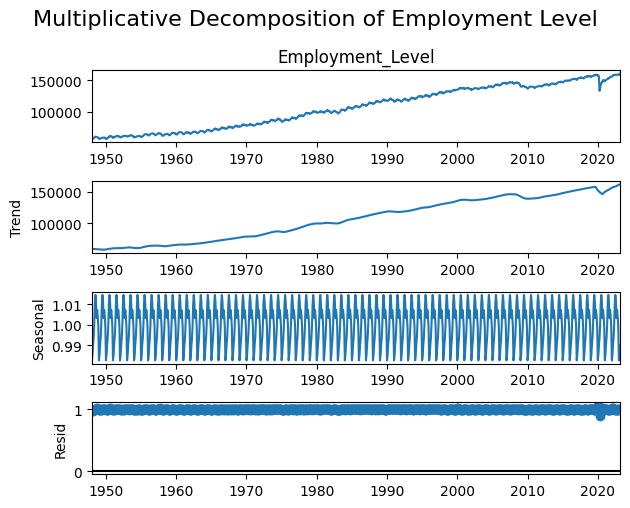

In [ ]:
# Perform multiplicative decomposition on the 'Value' variable
decompose_mult = seasonal_decompose(data['Employment_Level'], 
                              model='multiplicative', extrapolate_trend='freq')

# Set the figure size for the resulting decomposition plot
plt.figure(figsize=(15, 15))

# Plot the decomposition
decompose_mult.plot()

# Add a title and subtitle with appropriate spacing
plt.suptitle('Multiplicative Decomposition of Employment Level',
             y=1.05, fontsize=16)
plt.title('', y=1.15)

# Show the plot
plt.show()

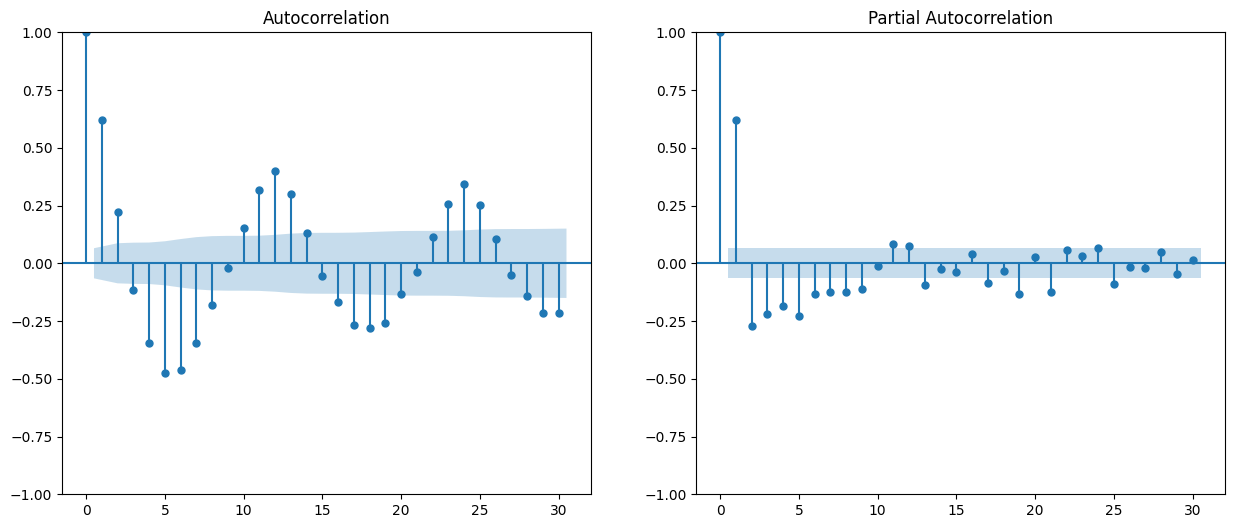

In [ ]:
# Remove Trend and Seasonality
trend = decompose_mult.trend
seasonality = decompose_mult.seasonal

resids_mult = data['Employment_Level'] / (trend * seasonality)

# Plot ACF and PACF of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(resids_mult, ax=ax1)
plot_pacf(resids_mult, ax=ax2)
plt.show()

After performing a multiplicative decomposition of the time-series data into its trend, seasonal, and residual components, we observed that the ACF and PACF plots of the residuals suggest the presence of some cyclicity. This indicates that there may be cyclical patterns in the data that have not been fully accounted for in the decomposition or that the data.

#### **(c) Which decomposition is better, additive or multiplicative? Why?**

Based on the characteristics of the time series data, we found that an additive decomposition approach was more appropriate. This is because the amplitude of the seasonality remains constant with the increasing trend in the data, which is a key feature of additive decomposition. Additionally, the residuals
produced by the additive decomposition approach were better suited for further analysis than those produced by the multiplicative decomposition approach. Lastly, both the multiplicative decomposition and the additive decomposition suggest evidence of cyclicity within the data. 

#### **(d) Based on the two decompositions, and interpretation of the random components, would your models for the cycles be similar (additive vs multiplicative) or very different? Why?**

Based on the two decompositions and the interpretation of the residuals (random components) above, the models for the cycles would be similar for the additive and multiplicative decompositions. Both decompositions capture similar patterns in residuals plotted above as well as similar patterns in the ACF and PACF of residuals.

#### **(e) Plot the seasonal factors and comment on the plot.**

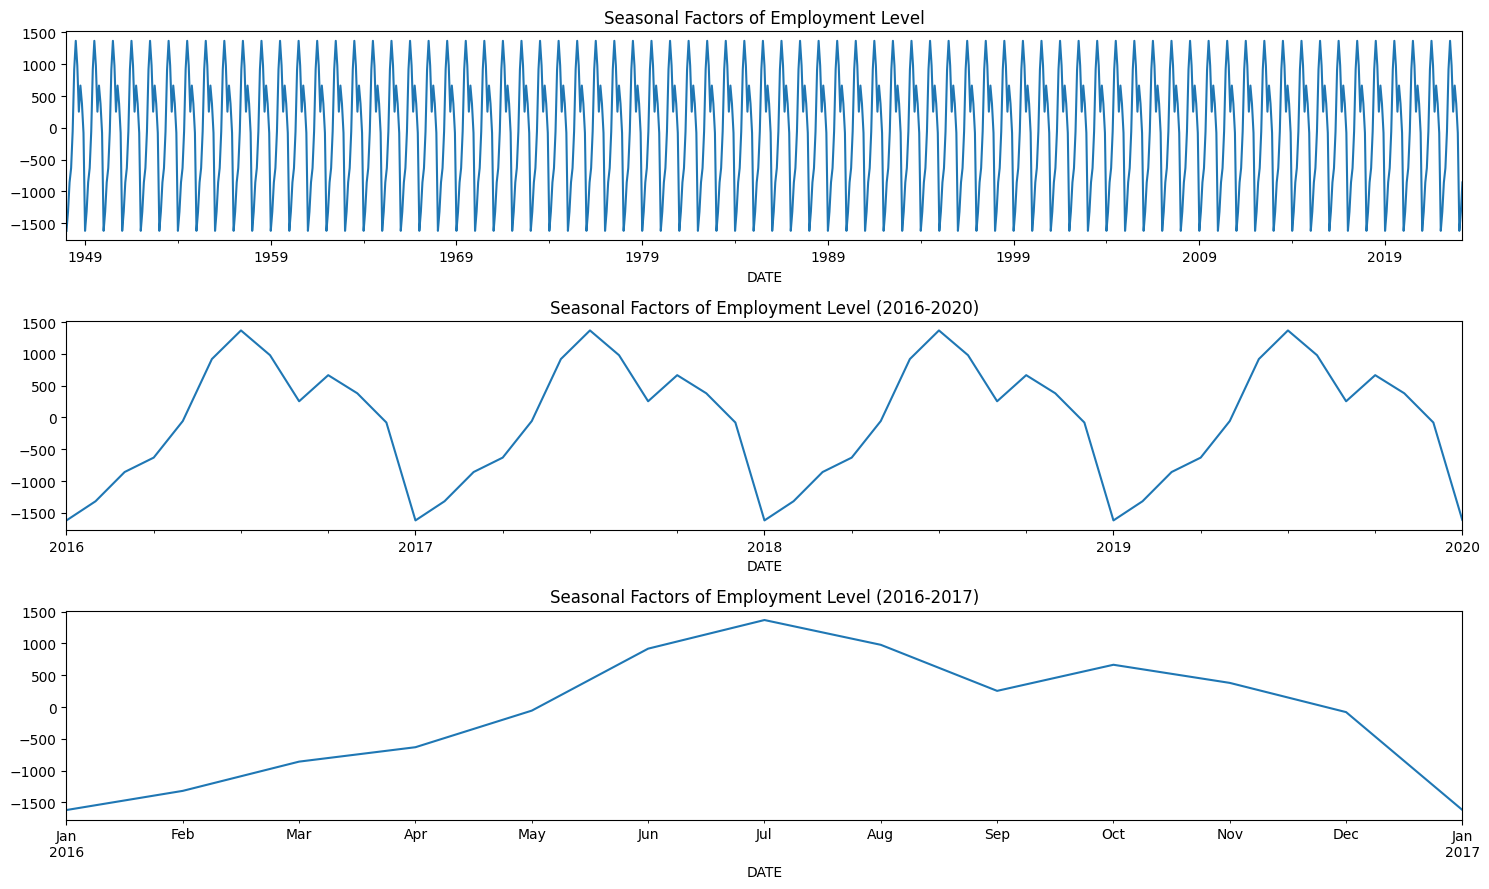

In [ ]:
# Set the figure size for the resulting decomposition plot
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 9))

# Plot the seasonal factors on the first subplot
decompose_add.seasonal.plot(ax=ax0)
ax0.set_title('Seasonal Factors of Employment Level')

# Plot the seasonal factors on the second subplot
decompose_add.seasonal.plot(ax=ax1)
ax1.set_title('Seasonal Factors of Employment Level (2016-2020)')
ax1.set_xlim(left=pd.Timestamp('2016-01-01'), right=pd.Timestamp('2020-01-01'))

# Plot the seasonal factors on the third subplot
decompose_add.seasonal.plot(ax=ax2)
ax2.set_title('Seasonal Factors of Employment Level (2016-2017)')
ax2.set_xlim(left=pd.Timestamp('2016-01-01'), right=pd.Timestamp('2017-01-01'))

# Show the plot
plt.tight_layout()
plt.show()

Based on the above plot, it seems that within each year there is a relatively consistent seasonal pattern - employment level peaks over the summer, after rising steadily through the spring months, and then declines slowly through the latter half of the year - with a small resurgence between September and October

#### **(f) Based on your analysis thus far, choose a model that includes your preferred trend and seasonal model to forecast 12-steps ahead, and show the plot of the data, respective fit, and forecast.**
Based on our analysis thus far, we can improve our model of just a trend to build a model that includes trend and seasonality. To do this, we will utilize the Holt-Winters model to produce our forecast. 

                       ExponentialSmoothing Model Results                       
Dep. Variable:         Employment_Level   No. Observations:                  863
Model:             ExponentialSmoothing   SSE                      137955115.186
Optimized:                         True   AIC                          10372.487
Trend:                         Additive   BIC                          10448.654
Seasonal:                      Additive   AICC                         10373.297
Seasonal Periods:                    12   Date:                 Sat, 22 Apr 2023
Box-Cox:                          False   Time:                         01:30:29
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7394023                alpha                 True
smoothing_trend          

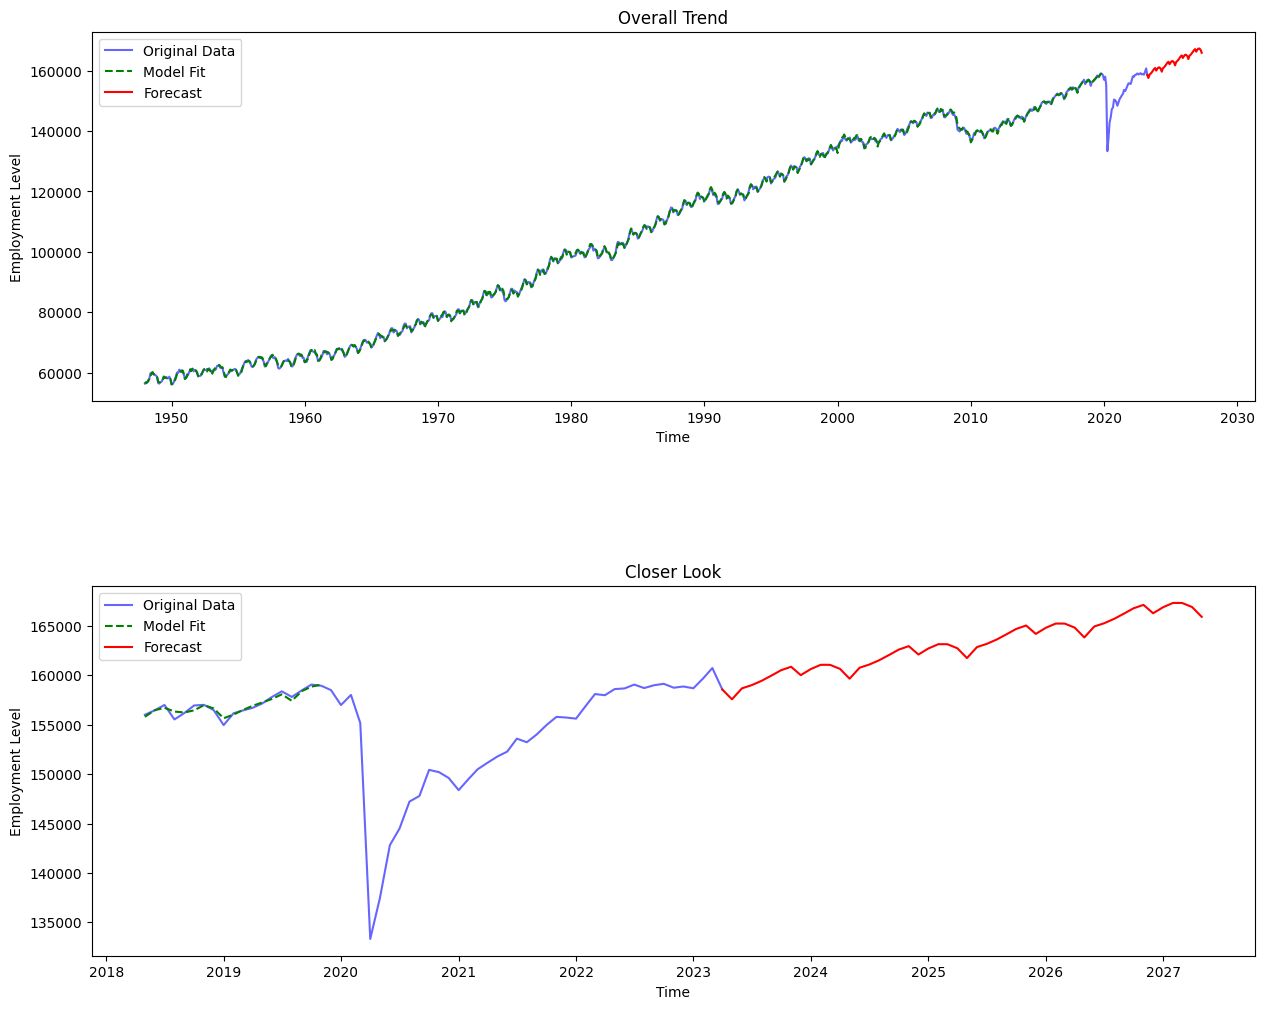

In [ ]:
# Use all observations before the COVID-19 pandemic as training data
train_data = data.iloc[:-40] 
    # Drop the last 40 time steps to exclude the COVID-19 pandemic period shock

# Set number of forecasts
n_forecasts = 50   

# Fit the Holt-Winters model
model = ExponentialSmoothing(train_data['Employment_Level'], trend='add', 
                             seasonal='add', seasonal_periods=12)
results = model.fit()

# Print the Model Fit
print(results.summary())
print('\n')

# Fitted Values
model_fitted = results.fittedvalues


# Set start date to the last date in the data DataFrame
start_date = data.iloc[-1:,:].index[0]
TimeStamp = pd.date_range(start=start_date, periods=n_forecasts +1 , 
                          freq='MS').tolist()

# Forecast for the next n periods
forecasts = results.forecast(steps=n_forecasts)

# Create a DataFrame for forecasts
forecasts = pd.DataFrame(np.array(forecasts), index=TimeStamp[1:], 
                         columns=['Predictions'])

# Merge data
forecasts = forecasts.rename(columns={'Predictions':'Employment_Level'})
merged_df = pd.concat([data, forecasts])

# Split the data into two sets based on a date
split_date = pd.to_datetime('2023-04-01')
pre_date = merged_df.loc[:split_date]
pre_date['Fitted'] = model_fitted
post_date = merged_df.loc[split_date:]

# Ploting 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

ax[0].plot(pre_date['Employment_Level'], label='Original Data', 
           alpha = 0.6, color='blue')
ax[0].plot(pre_date['Fitted'], label = 'Model Fit', color = 'green', 
           linestyle = '--')
ax[0].plot(post_date['Employment_Level'], label='Forecast', color='red')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Employment Level')
ax[0].legend()
ax[0].set_title('Overall Trend')

ax[1].plot(pre_date['Employment_Level'].iloc[-60:], label='Original Data', 
           color='blue', alpha = 0.6)
ax[1].plot(pre_date['Fitted'].iloc[-60:], label = 'Model Fit', color = 'green', 
           linestyle = '--')
ax[1].plot(post_date['Employment_Level'], label='Forecast', color='red')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Employment Level')
ax[1].legend()
ax[1].set_title('Closer Look')

plt.subplots_adjust(hspace=0.5)
plt.show()

## **III. Conclusions and Future Work**
The model using Holt-Winters forecasting method performs much better than our first model with simple quadratic regression. We can see how the Holt-Winters method captures the seasonality and provides a more accurate and realistic visualization.

Using time series analysis, we can see how employment has been increasing over the years as the U.S. population has increased - excluding a decline in employment during the COVID-19 pandemic. Employment is clearly cyclical, and has a clear seasonal pattern each year. Our forecast shows that employment overall will continue to increase over the next 12 months.

We could use more data to improve the accuracy of our model, and could also adopt more advanced forecasting methods such as an ARIMA model to get a better forecast. We could also use a different dataset to see how the model performs. Another improvement to the forecast could occur if we could include sentiment analysis. 

## **IV. References**

Employment level. FRED. (2023, April 7). Retrieved April 16, 2023, from https://fred.stlouisfed.org/series/LNU02000000 